<a href="https://colab.research.google.com/github/abhishek-shrm/discharge-pressure-prediction/blob/master/discharge_pressure_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Discharge Pressure Prediction**
Welcome to the Discharge Pressure prediction project. It is a regression problem where I have to predict Discharge Pressure in psig.


In [0]:
# Installing tensorflow 2.0+ for this project
!pip install tensorflow-gpu

In [0]:
# Importing tensorflow and checking its version
import os
import tensorflow as tf
print(tf.__version__)

2.1.0


In this project, I am using Bayesian optimization for tuning hyperparameters of different models. Bayesian optimization is based on Bayesian inference and the Gaussian process. It is an open-source package used for finding the maximum value of an unknown function in as few iterations as possible. It is very fast when compared to other hyperparameter optimizers like, GridSearch and RandomSearch.

In [0]:
# Installing bayesian-optimization package
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=06531569e80e205606ce35201551d05cb2af77cd742f5bd578105a5149f3a642
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
# Importing all the required libraries
import numpy as np 
import pandas as pd # for handling dataframes
from sklearn.preprocessing import StandardScaler #Standardizing the data
import time # for doing processes related to time
from bayes_opt import BayesianOptimization #for hyperparameter tuning
from sklearn.externals import joblib # for saving models

# for neural network related processes
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# for splitting the database
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

# for calculating mean squared error, visualization and others
from sklearn.metrics import mean_squared_error
import seaborn as sns
import math
import statistics
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

I found this function on the internet, which nicely formats the time.

In [0]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

#### **Problem Statement**
To predict Discharge Pressure in *psig*.

#### **Data Understanding and Pre-processing**

I have downloaded the dataset and uploaded it to my GitHub repository so that I can easily access it inside the Google Colab. Now, I am loading the dataset and displaying first 5 rows of it.

In [0]:
df=pd.read_csv('https://raw.githubusercontent.com/abhishek-shrm/discharge-pressure-prediction/master/Expander_data.csv')
df.head()

,Timestamp,Suction Pressure (psig),Suction Temperature (F),Total Flow (gpm),Speed (rpm),By-pass Valve Position (%),Discharge Pressure (psig),Discharge Temperature (F),Run Status
0,1/4/2020 21:20,596.100853,-229.436683,7925.800487,2999.411045,6.0,226.044931,-227.614448,NaN
1,1/4/2020 21:20,596.838217,-230.453708,8085.917724,2989.706617,6.0,217.150974,-228.668636,NaN
2,1/4/2020 21:20,596.468895,-229.545356,7902.175243,3006.331679,6.0,226.054086,-227.755324,NaN
3,1/4/2020 21:20,603.568271,-230.309438,7991.808959,3010.487486,6.0,226.016182,-228.489113,NaN
4,1/4/2020 21:21,595.407372,-229.767969,7871.560747,2986.665518,6.0,227.769383,-227.971795,NaN


Let's take a look at different properties of the dataset.

In [0]:
# Shape of data
df.shape

(296450, 9)

In [0]:
# List of columns in dataset
df.columns

Index(['Timestamp', 'Suction Pressure (psig)', 'Suction Temperature (F)',
       'Total Flow (gpm)', 'Speed (rpm)', 'By-pass Valve Position (%)',
       'Discharge Pressure (psig)', 'Discharge Temperature (F)', 'Run Status'],
      dtype='object')

In [0]:
# Getting information about data types of features in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296450 entries, 0 to 296449
Data columns (total 9 columns):
Timestamp                     296450 non-null object
Suction Pressure (psig)       296450 non-null float64
Suction Temperature (F)       296450 non-null float64
Total Flow (gpm)              296450 non-null float64
Speed (rpm)                   296450 non-null float64
By-pass Valve Position (%)    296450 non-null float64
Discharge Pressure (psig)     296450 non-null float64
Discharge Temperature (F)     296450 non-null float64
Run Status                    0 non-null float64
dtypes: float64(8), object(1)
memory usage: 20.4+ MB


Let's do a descriptive statistical analysis of the data.

In [0]:
df.describe()

,Suction Pressure (psig),Suction Temperature (F),Total Flow (gpm),Speed (rpm),By-pass Valve Position (%),Discharge Pressure (psig),Discharge Temperature (F),Run Status
count,296450.000000,296450.000000,296450.000000,296450.000000,296450.000000,296450.000000,296450.000000,0.0
mean,590.541350,-231.564934,8119.917777,2955.416695,2.005667,186.991087,-229.764934,NaN
std,23.216552,3.574107,398.049531,54.201467,2.488568,56.205183,3.574136,NaN
min,552.420048,-238.594971,7056.004500,2835.750571,-0.200000,69.983885,-236.816223,NaN
25%,572.757269,-234.171427,7916.322054,2906.336126,0.000000,143.468467,-232.371760,NaN
50%,586.491792,-230.922352,8144.161813,2961.788792,0.000000,183.270451,-229.122946,NaN
75%,605.986608,-229.585168,8388.610374,3000.863611,4.000000,223.580205,-227.785796,NaN
max,649.217417,-223.440125,8975.986378,3090.367995,8.026667,324.411576,-221.617102,NaN


Given data is a time series, but since we have to do the regression, the order of data does not matter. Second, the 'Run Status' column is empty. It is full of NaN values. Therefore, I am dropping both the 'Timestamp' and 'Run status' column.

In [0]:
df.drop(columns=['Timestamp','Run Status'],inplace=True)

Let's check if there is any null value present in the dataset.

In [0]:
# No. of null values in each column
df.isnull().sum()

Suction Pressure (psig)       0
Suction Temperature (F)       0
Total Flow (gpm)              0
Speed (rpm)                   0
By-pass Valve Position (%)    0
Discharge Pressure (psig)     0
Discharge Temperature (F)     0
dtype: int64

Since the data is little on the bigger side with about 296450 rows, it is better to check for redundancy (duplicate rows) in the dataset.

In [0]:
# Looking for redundancy
df.duplicated(keep='first').value_counts()

False    296450
dtype: int64

Now, I am plotting box plots to see if there are any outliers present in the dataset.

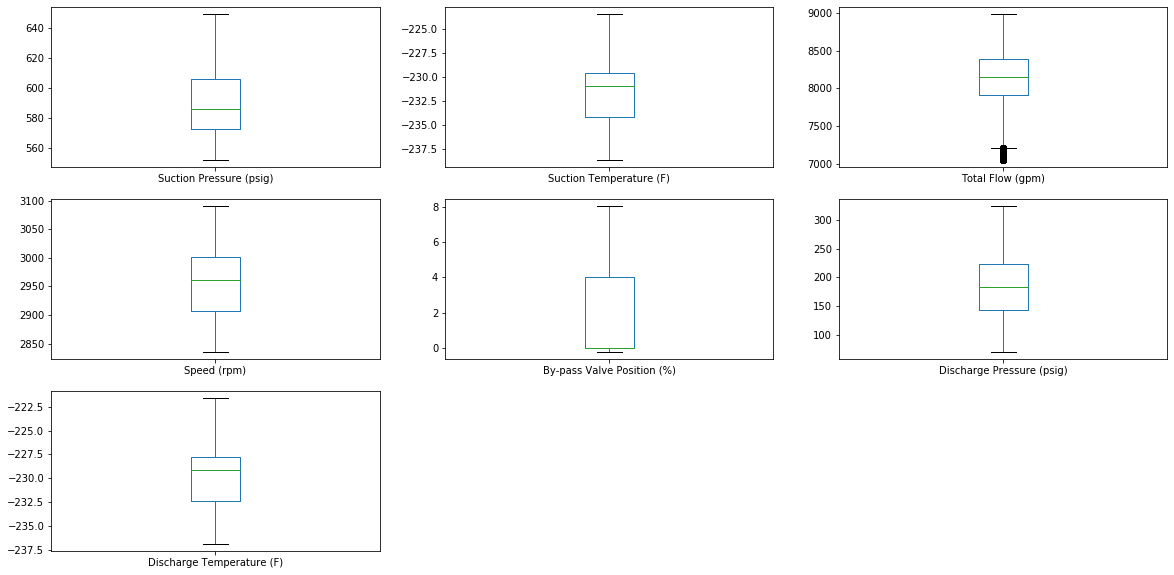

In [0]:
#looking for outliers
for i in zip(range(1,8),df.columns):
  plt.subplot(3,3,i[0])
  df[i[1]].plot(kind='box',figsize=(20,10))
plt.show()

'Total Flow (gpm)' column has outliers, but these are great in numbers. Removing these will profoundly affect our dataset. Therefore, I am keeping these outliers in the dataset so that we don't lose a large chunk of data. Now, let's see how each feature affects or correlated to the Discharge Pressure. For this, I am using heatmaps. Heatmaps are a great visualization tool that plots the color-coded correlation matrix of a dataset. I am using the seaborn library for this.

[Text(0.5, 0, 'Suction Pressure (psig)'),
 Text(1.5, 0, 'Suction Temperature (F)'),
 Text(2.5, 0, 'Total Flow (gpm)'),
 Text(3.5, 0, 'Speed (rpm)'),
 Text(4.5, 0, 'By-pass Valve Position (%)'),
 Text(5.5, 0, 'Discharge Pressure (psig)'),
 Text(6.5, 0, 'Discharge Temperature (F)')]

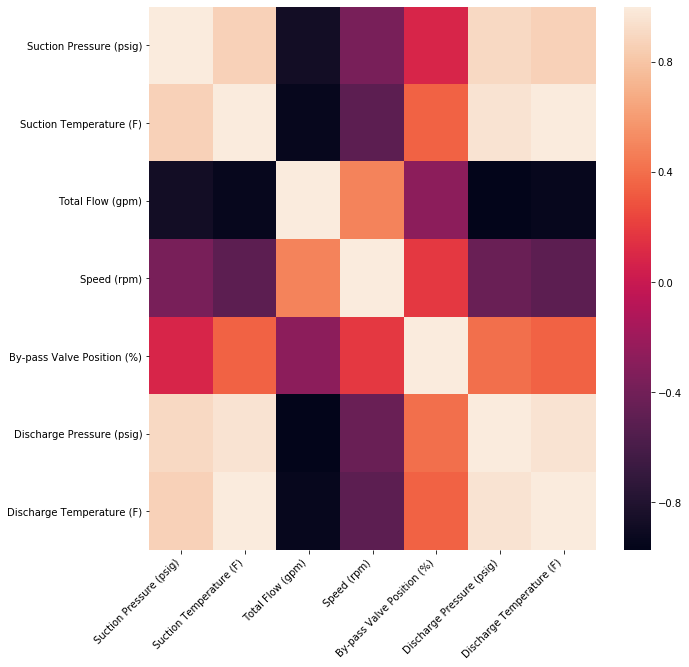

In [0]:
#Checking correlation of features
# calculate the correlation matrix
corr = df.corr()
#plotting heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

From the heatmaps, it can be concluded that there is a strong positive correlation between Discharge Pressure, Suction Pressure, Suction temperature, and Discharge Temperature. There is also a negative correlation between Total Flow and Speed. All the features are correlated with the Discharge Pressure. Therefore we don't have to do any feature engineering. Creating new features can increase the complexity of the data, and it will require more sophisticated models for prediction.

Now, I am separating predictor(X), and target(Y) features from the 
dataset.

In [0]:
X=df.drop(columns=['Discharge Pressure (psig)']).values
X.shape

(296450, 6)

In [0]:
Y=df['Discharge Pressure (psig)'].values
Y.shape

(296450,)

In [0]:
# Setting value for random seed
random.seed(42)

I am splitting the dataset into training and test set. For this, I am using the train_test_split function of Sklearn. The training set has 80%, and the testing set has 20% of the data.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(237160, 6) (59290, 6) (237160,) (59290,)


I am standardizing the data about mean and standard deviation using StandardScalar() from Sklearn.

In [0]:
# Standardizing dataset
sc=StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform (X_test)

### **Modeling**
Now, I am moving to the next phase of this data science project that is Modeling. In this phase, I am training and testing some models on the given dataset. Later, I am doing a comparative analysis of the results produced by each model. Let's start with the simplest model, i.e., Multiple Linear Regression.

#### **Multiple Linear Regression**
In Multiple Linear Regression, we try to fit a linear function for the different features and predict the target variable.

In [0]:
# Importing Linear Regression
from sklearn.linear_model import LinearRegression

In [0]:
# Training the model on the standardized dataset
# For displaying time took
start_time=time.time()
lm=LinearRegression()
lm.fit(X_train_scaled,Y_train)
time_took = time.time() - start_time  
print(f"Total runtime: {hms_string(time_took)}")

Total runtime: 0:00:00.06


In [0]:
# Parameters of the trained model
print('Slope=>',lm.coef_)
print('Intercept=>',lm.intercept_)

Slope=> [ 21.05007271   3.68116229 -28.04750687  -3.49411707  12.341123
  -0.25000145]
Intercept=> 187.02991678089205


In [0]:
# Getting predictions on the standardized test set
lm_pred=lm.predict(X_test_scaled)

In [0]:
# Calculating RMSE of the model on the test set
print('RMSE for Multiple Linear Regression=>',np.sqrt(mean_squared_error(Y_test,lm_pred)))

RMSE for Multiple Linear Regression=> 2.4545057206601055


#### **Multi-Dimensional Polynomial Regression**
Sometimes, linear functions are not able to fit the data correctly; therefore, now we are trying to use a polynomial function. In Multi-Dimensional Polynomial Regression, we try to fit a polynomial function for the different features and predict the target variable.

In [0]:
# Importing required objects for Multi-Dimensional Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

Here, I have created a function poly_deg, which takes a degree as input for polynomial function and creates a pipeline for it. It performs 5-fold cross-validation, and returns mean RMSE for the model.

In [0]:
def poly_reg(deg):
  # For bootstrapping and 5-fold cross validation
  boot=ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
  # Tracking score
  mean_rmse=[]
  num=0

  #Looping through samples
  for train,test in boot.split(X):
    num+=1

    #Split train and test
    stdScaler=StandardScaler()
    x_train=stdScaler.fit_transform(X[train])
    y_train=Y[train]
    x_test=stdScaler.transform(X[test])
    y_test=Y[test]

    #constructing model and training
    Input=[('polynomial',PolynomialFeatures(degree=int(deg))),('modal',LinearRegression())]
    pipe=Pipeline(Input)
    pipe.fit(x_train,y_train)
    p_pred=pipe.predict(x_test)
    #evaluating
    score=np.sqrt(mean_squared_error(y_test,p_pred))
    mean_rmse.append(score)
  
  return statistics.mean(mean_rmse)

In [0]:
# Iterating through 1 to 7 and checking RMSE for model
for i in range(1,8):
  print('RMSE=>',poly_reg(i),', Degree=>',i)

RMSE=> 2.4562039416061823 , Degree=> 1
RMSE=> 1.225577111599554 , Degree=> 2
RMSE=> 1.2236481554692085 , Degree=> 3
RMSE=> 1.2222101112752695 , Degree=> 4
RMSE=> 1.221169792837067 , Degree=> 5
RMSE=> 1.2198157049713059 , Degree=> 6
RMSE=> 1.2216676124608152 , Degree=> 7


As we can see, Polynomial Function with degree=6 fits the data pretty well with RMSE of 1.2198157049713059. Let's train a model with the best degree polynomial and check its prediction power on our testing set.

In [0]:
# Training with best degree polynomial
Input=[('polynomial',PolynomialFeatures(degree=6)),('modal',LinearRegression())]
pipe=Pipeline(Input)
start_time=time.time()
pipe.fit(X_train_scaled,Y_train)
p_pred=pipe.predict(X_test_scaled)
#evaluating
time_took = time.time() - start_time  
print(f"Total runtime: {hms_string(time_took)}")
print('RMSE=>',np.sqrt(mean_squared_error(Y_test,p_pred)))

Total runtime: 0:00:20.92
RMSE=> 1.2163359424484355


#### **XGBoost Regressor**
Now, let's move on to tree-based regressor XGBoost to see if we can improve our RMSE with a different type of approach. XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It makes use of tree ensembles and makes predictions.

In [0]:
# Import XGBoost
import xgboost as xgb

First, we need to prepare data for the XGBoost algorithm. It takes data in the form of an optimized data structure called Dmatrix. It does not require the data to be standardized. Therefore, we are passing original data through DMatrix().

In [0]:
data_dmatrix = xgb.DMatrix(data=X,label=Y)

I have created a function xgb_reg, which takes learning rate and max depth as input. It performs 5-fold cross-validation on XGB Regressor and returns RMSE for each set of parameters.

In [0]:
def xgb_reg(learning_rate,max_depth):
  params={"objective":"reg:squarederror","learning_rate":learning_rate,"max_depth":int(max_depth)}
  cv_results=xgb.cv(params=params,dtrain=data_dmatrix,num_boost_round=50,nfold=5,early_stopping_rounds=10,metrics="rmse",seed=42)
  return -(cv_results['test-rmse-mean'].min())

Now, I am using Bayesian optimization to tune the hyperparameters of XGB Regressor. The optimizer returns the best parameters for the model.

In [0]:
# Using Bayesian Optimization for hyperparameter tuning of xgb regressor
pspace={
    'learning_rate':(0.001,0.3),
    'max_depth':(3,15)
}
#Running optimizer
optimizer=BayesianOptimization(f=xgb_reg,pbounds=pspace,random_state=42,verbose=2)
start_time = time.time()
optimizer.maximize(init_points=10,n_iter=30)
time_took = time.time() - start_time
  
print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
|  1        | -1.398    |  0.113    |  14.41    |
|  2        | -1.344    |  0.2199   |  10.18    |
|  3        | -17.42    |  0.04765  |  4.872    |
|  4        | -77.17    |  0.01837  |  13.39    |
|  5        | -1.323    |  0.1807   |  11.5     |
|  6        | -136.1    |  0.007155 |  14.64    |
|  7        | -1.662    |  0.2499   |  5.548    |
|  8        | -11.62    |  0.05537  |  5.201    |
|  9        | -2.082    |  0.09197  |  9.297    |
|  10       | -1.533    |  0.1302   |  6.495    |
|  11       | -2.541    |  0.1929   |  3.767    |
|  12       | -2.804    |  0.1415   |  3.168    |
|  13       | -50.45    |  0.0267   |  6.203    |
|  14       | -2.178    |  0.09091  |  8.739    |
|  15       | -11.61    |  0.05519  |  6.014    |
|  16       | -4.944    |  0.07294  |  5.424    |
|  17       | -1.417    |  0.2205   |  7.321    |
|  18       | -1.339    |  0.1298   |  9.04     |


Now, I am training an XGB Regressor on the best parameters returned by the Bayesian optimizer. Then, I am evaluating it on the testing dataset.

In [0]:
start_time=time.time()
xg_reg=xgb.XGBRegressor(objective="reg:squarederror",learning_rate=0.178,max_depth=11)
xg_reg.fit(X_train,Y_train)
xgb_pred = xg_reg.predict(X_test)
#evaluating
time_took = time.time() - start_time  
print(f"Total runtime: {hms_string(time_took)}")
print('RMSE=>',np.sqrt(mean_squared_error(Y_test,xgb_pred)))

Total runtime: 0:00:49.00
RMSE=> 1.3080269271208989


#### **Multi-Layer Perceptron**
Finally, let's move on to neural networks. I have tried to keep it simple. Therefore, I am using Multi-Layer Perceptron with few layers only. I have created a function generate_model which takes dropout value, no. of layers, neuron count for 1st layer and shrink percentage( the value by which the no. of neurons gets reduced with each successive layer). This function generates the model using Keras and returns it.

In [0]:
# Function for generating model
def generate_model(dropout, layers,neuronCount,shrinkPercentage):
  #adding sequential layer
  model=Sequential()
  layer=0
  while neuronCount>6 and layer<layers:
    if layer==0:
      #Creating 1st layer
      model.add(Dense(neuronCount,input_dim=6,activation='relu'))
    else:
      #adding other layers
      model.add(Dense(neuronCount,activation='relu'))
    layer+=1
    model.add(Dropout(dropout))
    #Setting no. of neuron for next layer
    neuronCount=int(neuronCount*(1-shrinkPercentage))
  #adding last layer
  model.add(Dense(1))
  #Returning the model
  return model

I have also created a function evaluate_neural_network which takes parameters similar to generate_model function with additional parameters such as batch size, and learning rate. This function calls the generate_model function to create the model. It performs the 2-fold cross-validation on the model and returns the negative of the RMSE. This function returns negative of RMSE because we have to reduce it.

In [0]:
# Function for evaluating model
def evaluate_neural_network(dropout, layers, batchSize,neuronCount,shrinkPercentage,lr):
  SPLITS = 2
  
  # Bootstrap
  boot = ShuffleSplit(n_splits=SPLITS, test_size=0.2)
  
  # Track progress
  mean_benchmark = []
  epochs_needed = []
  num = 0

  # Loop through samples
  for train, test in boot.split(X):
    start_time = time.time()
    num+=1

    #Split train and test
    stdScaler=StandardScaler()
    x_train=stdScaler.fit_transform(X[train])
    y_train=Y[train]
    x_test=stdScaler.transform(X[test])
    y_test=Y[test]
    #Generating model
    model=generate_model(dropout, layers,int(neuronCount),shrinkPercentage)
    #Compiling model
    model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=lr))
    # Setting monitor for early stopping
    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=25,verbose=0,mode='auto',restore_best_weights=True)
    #Training
    model.fit(x_train,y_train,batch_size=int(batchSize),validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=100)
    #Validating
    pred=model.predict(x_test)
    #Evaluating on RMSE
    score=np.sqrt(mean_squared_error(y_test,pred))
    mean_benchmark.append(score)
    # Taking mean RMSE of 2-folds
    m1 = statistics.mean(mean_benchmark)
  
  #Clearing session
  tensorflow.keras.backend.clear_session()
  return(-m1)

Here, I am using Bayesian optimization to tune the hyperparameters of Multi-Layer Perceptron. The optimizer returns the best parameters for the model.

In [0]:
# Bounding region for parameter space
  pspace={
      'dropout':(0.1,0.3),
      'layers':(2,7),
      'batchSize':(200,2000),
      'neuronCount':(200,2048),
      'shrinkPercentage':(0.1,0.9),
      'lr':(0.001,0.2)
  }
  #Running optimizer
  optimizer=BayesianOptimization(f=evaluate_neural_network,pbounds=pspace,random_state=42,verbose=0)
  optimizer.maximize(init_points=10, n_iter=70,)
  print(optimizer.max)

{'target': -1.893814596423903, 'params': {'batchSize': 256.77401084167416608 ,'dropout': 0.19871198428037775, 'lr': 0.00199884168713823,'layers': 3.08416411119650065, 'neuronCount': 200.25107746556382315, 'shrinkPercentage': 0.2484788676498257}}


Now, I am generating a multi-layer perceptron with the hyper-parameters returned by Bayesian optimizer.

In [0]:
model=generate_model(0.2,3,200,0.25)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 200)               1400      
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_19 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 112)               16912     
_________________________________________________________________
dropout_20 (Dropout)         (None, 112)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                

In [0]:
# Compiling model and initializing a early stopping monitor
model.compile(loss='mean_squared_error',optimizer=Adam(0.002))
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=25,verbose=1,mode='auto',restore_best_weights=True)

Here, I am training the model on the standardized dataset because neural networks perform better when data is about 0.

In [0]:
# Training the model
hist=model.fit(X_train_scaled,Y_train,batch_size=256,epochs=1000,callbacks=[monitor],validation_data=(X_test_scaled,Y_test))

Train on 237160 samples, validate on 59290 samples
Epoch 1/1000
237160/237160 [==============================] - 3s 12us/sample - loss: 1325.8797 - val_loss: 10.1971
Epoch 2/1000
237160/237160 [==============================] - 3s 11us/sample - loss: 272.2406 - val_loss: 10.2411
Epoch 3/1000
237160/237160 [==============================] - 2s 10us/sample - loss: 256.4016 - val_loss: 54.5067
Epoch 4/1000
237160/237160 [==============================] - 2s 10us/sample - loss: 241.3825 - val_loss: 2.6985
Epoch 5/1000
237160/237160 [==============================] - 2s 10us/sample - loss: 230.6207 - val_loss: 19.1471
Epoch 6/1000
237160/237160 [==============================] - 2s 10us/sample - loss: 220.5642 - val_loss: 7.0579
Epoch 7/1000
237160/237160 [==============================] - 2s 10us/sample - loss: 210.9531 - val_loss: 6.4511
Epoch 8/1000
237160/237160 [==============================] - 3s 11us/sample - loss: 201.6510 - val_loss: 13.4314
Epoch 9/1000
237160/237160 [===========

In [0]:
# Evaluating model
nn_pred=model.predict(X_test_scaled)
print(np.sqrt(mean_squared_error(Y_test,nn_pred)))

1.6427176582267096


### **Results**
Now, as I have finished my modeling phase, it's time to analyze the results.

| Model                                    | RMSE               |
|------------------------------------------|--------------------|
| Multiple Linear Regression               | 2.4545057206601055 |
| Multi-Dimensional Polynomial Regresssion | 1.2163359424484355 |
| XGBoost Regressor                        | 1.3080269271208989 |
| Multi-Layer Perceptron                   | 1.6427176582267096 |

As you can see, the Multi-Dimensional Polynomial Regression model performed better than all other models. It has the lowest RMSE among all succeeding the XGBoost Regressor with the slightest margin.

### **Final**
Now, it is time to prepare our final model. I am now creating a pipeline comprising of StandardScaler(), PolynomialFeatures(), and LinearRegression().

In [0]:
Input=[('standard-scaler',StandardScaler()),('polynomial',PolynomialFeatures(degree=6)),('modal',LinearRegression())]
pipe=Pipeline(Input)

Here, I am fitting the model on the whole original dataset. It will standardize the dataset itself.

In [0]:
pipe.fit(X,Y)

Pipeline(memory=None,
         steps=[('standard-scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('modal',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

I am saving the model in the form of pickle.

In [0]:
joblib.dump(pipe,'model.pkl')

['model.pkl']